In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme(style='whitegrid')

In [2]:
#load the data

train = pd.read_csv('../data/processed_data/train.csv')
test = pd.read_csv('../data/processed_data/test.csv')

In [3]:
#Chaning categorical variables to numerical variables 

train['bin_class']=pd.factorize(train['bin'])[0]
train['drug_class']=pd.factorize(train['drug'])[0]

test['bin_class']=pd.factorize(test['bin'])[0]
test['drug_class']=pd.factorize(test['drug'])[0]

## Feature importance for pharmacy claim approval

In [4]:
from sklearn.ensemble import RandomForestClassifier

Since all the features from PA data is not relevant for prediction of pharmacy claim approval, I only include the feature from dim_claims.csv and dim_dates.csv in the predicition of pharmacy claim approval. 

In [5]:
feature_names = [
 'calendar_year',
 'calendar_month',
 'calendar_day',
 'day_of_week',
 'is_weekday',
 'is_workday',
 'is_holiday',
 'bin_class',
 'drug_class']
forest = RandomForestClassifier(random_state=34)
forest.fit(train[feature_names],train.pharmacy_claim_approved)

RandomForestClassifier(random_state=34)

#### Feature importance based on mean decrease in impurity

In [6]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.016 seconds


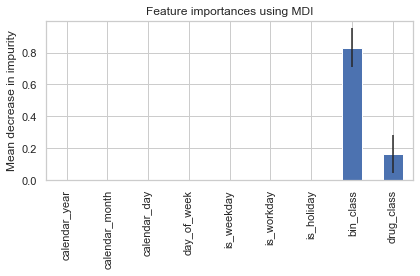

In [7]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Feature importance based on feature permutation

In [8]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, test[feature_names],test.pharmacy_claim_approved, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Elapsed time to compute the importances: 159.272 seconds


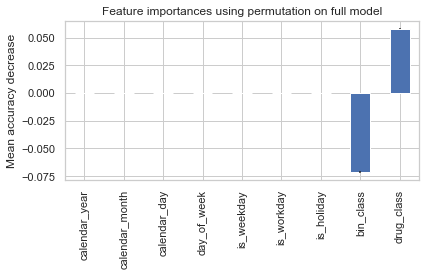

In [9]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

From the figure above the most important features are 'bin' and 'drug'. So I will consider these two features and their interaction in the following classification models. 

## Feature importance for PA approval

In this case features from all data are important. So I inlude all features. 

In [10]:
pa_feature_names = feature_names = [
 'calendar_year',
 'calendar_month',
 'calendar_day',
 'day_of_week',
 'is_weekday',
 'is_workday',
 'is_holiday',
 'bin_class',
 'drug_class',
 'correct_diagnosis',
 'tried_and_failed',
 'contraindication']
forest1 = RandomForestClassifier(random_state=342)
forest1.fit(train[train.pharmacy_claim_approved==0][pa_feature_names],train[train.pharmacy_claim_approved==0].pa_approved)

RandomForestClassifier(random_state=342)

#### Feature importance based on mean decrease in impurity 

In [11]:
start_time = time.time()
importances1 = forest1.feature_importances_
std1 = np.std([tree.feature_importances_ for tree in forest1.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.085 seconds


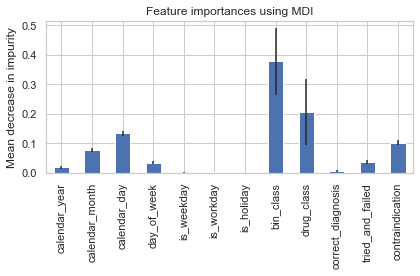

In [12]:
import pandas as pd

forest_importances1 = pd.Series(importances1, index=pa_feature_names)

fig, ax = plt.subplots()
forest_importances1.plot.bar(yerr=std1, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [13]:
forest_importances1 

calendar_year        0.019000
calendar_month       0.077588
calendar_day         0.134072
day_of_week          0.034454
is_weekday           0.001567
is_workday           0.001940
is_holiday           0.000830
bin_class            0.377610
drug_class           0.206032
correct_diagnosis    0.007919
tried_and_failed     0.036679
contraindication     0.102309
dtype: float64

#### Feature importance based on feature permutation

In [14]:
start_time = time.time()
result1 = permutation_importance(
    forest1, test[test.pharmacy_claim_approved==0][pa_feature_names],test[test.pharmacy_claim_approved==0].pharmacy_claim_approved, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances1 = pd.Series(result1.importances_mean, index=pa_feature_names)

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Elapsed time to compute the importances: 142.974 seconds


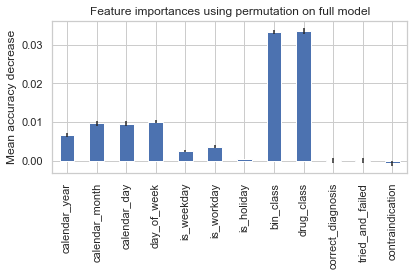

In [15]:
fig, ax = plt.subplots()
forest_importances1.plot.bar(yerr=result1.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [16]:
forest_importances1

calendar_year        0.006679
calendar_month       0.009718
calendar_day         0.009610
day_of_week          0.010054
is_weekday           0.002477
is_workday           0.003644
is_holiday           0.000354
bin_class            0.033353
drug_class           0.033608
correct_diagnosis    0.000045
tried_and_failed     0.000034
contraindication    -0.000743
dtype: float64

suprisingly correct diagnosis, tried_and_failed, contraindication have little importance score, while calendar day, clendar year, clendar month, week of day have higher importance score. 

 To understand why the date data have higher importance on PA approval, I do some count plots. 

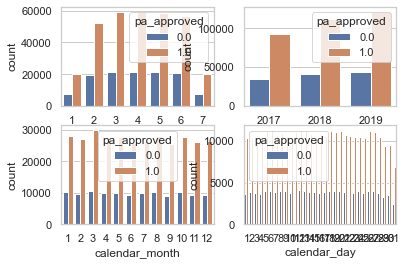

In [17]:
fig, axes = plt.subplots(2,2)

sns.countplot(ax=axes[0][0],x='day_of_week', data=train[train['pharmacy_claim_approved']==0], hue='pa_approved')
sns.countplot(ax=axes[0][1],x='calendar_year', data=train[train['pharmacy_claim_approved']==0], hue='pa_approved')
sns.countplot(ax=axes[1][0],x='calendar_month', data=train[train['pharmacy_claim_approved']==0], hue='pa_approved')
sns.countplot(ax=axes[1][1],x='calendar_day', data=train[train['pharmacy_claim_approved']==0], hue='pa_approved')

plt.show()

<AxesSubplot:xlabel='calendar_year', ylabel='count'>

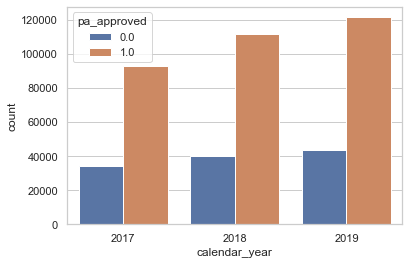

In [18]:
sns.countplot(x='calendar_year', data=train[train['pharmacy_claim_approved']==0], hue='pa_approved')

##### From the count plot it can be clearly seen that the PA approval rate does not much effected by these parameters!! So, why these parameters have hight importance score? Is it because the random forest feature importance score is not good metric for evaluating feautre importance?! If so what is best method for evaluating feature importance?

<AxesSubplot:xlabel='bin_class', ylabel='count'>

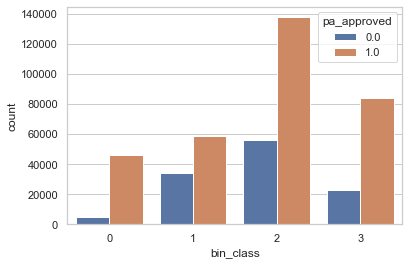

In [19]:
sns.countplot(x='bin_class', data=train[train['pharmacy_claim_approved']==0], hue='pa_approved')

<AxesSubplot:xlabel='drug_class', ylabel='count'>

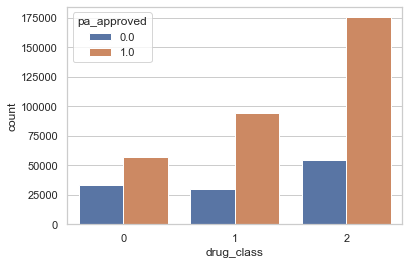

In [20]:
sns.countplot(x='drug_class', data=train[train['pharmacy_claim_approved']==0], hue='pa_approved')

<AxesSubplot:xlabel='contraindication', ylabel='count'>

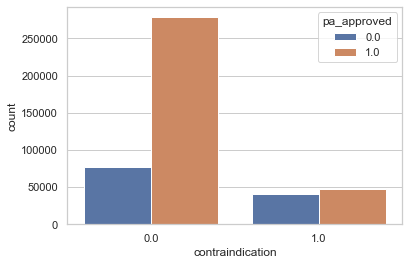

In [21]:
sns.countplot(x='contraindication', data=train[train['pharmacy_claim_approved']==0], hue='pa_approved')

<AxesSubplot:xlabel='correct_diagnosis', ylabel='count'>

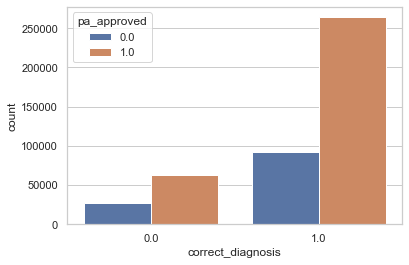

In [22]:
sns.countplot(x='correct_diagnosis', data=train[train['pharmacy_claim_approved']==0], hue='pa_approved')

<AxesSubplot:xlabel='tried_and_failed', ylabel='count'>

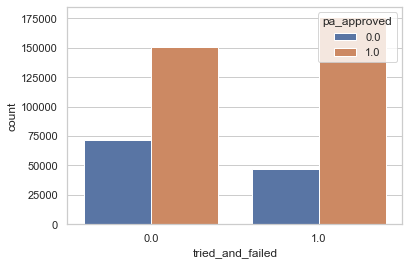

In [23]:
sns.countplot(x='tried_and_failed', data=train[train['pharmacy_claim_approved']==0], hue='pa_approved')

#### From the figures above, it can be seen that contraindication, bin, tried and failed, drug class have high affect on the PA approval rate, while the correct diagnosis has little affect on PA approval rate. 

## XGBoost classifier

In [24]:
import xgboost as xgb

### predict pharmacy claim approval

In [25]:
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(train[feature_names], train.pharmacy_claim_approved)

# Predict
preds = xgb_cl.predict(test[feature_names])

# Score

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:47:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
accuracy_score(test.pharmacy_claim_approved,preds)

1.0

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
conf_mat = confusion_matrix(test.pharmacy_claim_approved,preds)

In [29]:
conf_mat

array([[111191,      0],
       [     0, 155925]])

#### Hyperparameter optimization

In [30]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [31]:
from sklearn.model_selection import GridSearchCV

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=4, cv=3, scoring="roc_auc")

# Fit
grid_cv.fit(train[feature_names], train.pharmacy_claim_approved)

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:02:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [32]:
grid_cv.best_score_

1.0

In [33]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 0.8}

Only learning rate is in the middle of the its provided range. Other parameters are at the edge of provided range. So I keep exploring. 

In [34]:
# Insert the new fixed values to the grid
param_grid["subsample"] = [0.8]

# Give new value ranges to other params
param_grid["gamma"] = [0, 0.1, 0.5]
param_grid["max_depth"] = [2, 6, 9]
param_grid["reg_lambda"] = [0.1, 0.5, 5]
param_grid["learning_rate"] = [0.3, 0.5, 0.7, 1]
param_grid["scale_pos_weight"] = [0.3, 0.5, 0.7, 1]

In [37]:
grid_cv_2 = GridSearchCV(xgb_cl, param_grid, 
                         cv=3, scoring="roc_auc", n_jobs=-1)

_ = grid_cv_2.fit(train[feature_names], train.pharmacy_claim_approved)

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:14:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
grid_cv_2.best_score_

1.0

In [40]:
grid_cv_2.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.3,
 'max_depth': 2,
 'reg_lambda': 0.1,
 'scale_pos_weight': 0.3,
 'subsample': 0.8}

In [43]:
final_cl = xgb.XGBClassifier(
    **grid_cv_2.best_params_,
    objective="binary:logistic"
)

In [44]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

_ = final_cl.fit(train[feature_names], train.pharmacy_claim_approved)

preds = final_cl.predict(test[feature_names])

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:26:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [45]:
roc_auc_score(test.pharmacy_claim_approved,preds)

1.0

In [46]:
accuracy_score(test.pharmacy_claim_approved,preds)

1.0

## ADABoost classifier

In [47]:
from sklearn.ensemble import AdaBoostClassifier

### prediction of PA approval

In [48]:
from sklearn.model_selection import StratifiedKFold

In [94]:
ada = AdaBoostClassifier(random_state=235)

kfold = StratifiedKFold(shuffle=True, random_state=23) 

X_train = train[train.pharmacy_claim_approved==0][pa_feature_names]
y_train = train[train.pharmacy_claim_approved==0].pa_approved
X_test = test[test.pharmacy_claim_approved==0][pa_feature_names]
y_test = test[test.pharmacy_claim_approved==0].pa_approved

cv_acu = np.zeros(5)
cv_roc = np.zeros(5)

i=0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_train = X_train.iloc[train_index]
    X_holdout = X_train.iloc[test_index]
    y_train_train = y_train.iloc[train_index]
    y_holdout = y_train.iloc[test_index]
    
    ada.fit(X_train_train, y_train_train)
    pred = ada.predict(X_holdout)
    pred_prob = ada.predict_proba(X_holdout)
    cv_acu[i] = accuracy_score(y_holdout,pred)
    cv_roc[i] = roc_auc_score(pd.get_dummies(y_holdout),pred_prob)
    
    i+=1


In [96]:
cv_acu.mean()

0.7289616872020865

In [97]:
cv_roc.mean()

0.7271403996157335

In [98]:
ada = AdaBoostClassifier(random_state=235)

kfold = StratifiedKFold(shuffle=True, random_state=23) 

pa_features = [['bin_class','drug_class'],['bin_class','drug_class','contraindication'],
               ['bin_class','drug_class','contraindication','tried_and_failed'],
              ['bin_class','drug_class','contraindication','tried_and_failed','correct_diagnosis']]

X_train = train[train.pharmacy_claim_approved==0][pa_feature_names]
y_train = train[train.pharmacy_claim_approved==0].pa_approved
X_test = test[test.pharmacy_claim_approved==0][pa_feature_names]
y_test = test[test.pharmacy_claim_approved==0].pa_approved

cv_acu1 = np.zeros((5,len(pa_features)))
cv_roc1 = np.zeros((5,len(pa_features)))

i=0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_train = X_train.iloc[train_index]
    X_holdout = X_train.iloc[test_index]
    y_train_train = y_train.iloc[train_index]
    y_holdout = y_train.iloc[test_index]
    
    j=0
    for features in pa_features:
        ada.fit(X_train_train[features], y_train_train)
        pred = ada.predict(X_holdout[features])
        pred_prob = ada.predict_proba(X_holdout[features])
        cv_acu1[i,j] = accuracy_score(y_holdout,pred)
        cv_roc1[i,j] = roc_auc_score(pd.get_dummies(y_holdout),pred_prob)
        j+=1
    i+=1



In [99]:
np.mean(cv_acu1,axis=0)

array([0.67412537, 0.76905747, 0.72855473, 0.7290831 ])

In [100]:
np.argmax(np.mean(cv_roc1,axis=0))

2

In [101]:
print("The featrues that gives the best accuracy score is", pa_features[np.argmax(np.mean(cv_acu1,axis=0))], 
      ", which gives accuracy score of", np.round(np.max(np.mean(cv_acu1,axis=0)),4))

The featrues that gives the best accuracy score is ['bin_class', 'drug_class', 'contraindication'] , which gives accuracy score of 0.7691


In [102]:
print("The featrues that gives the best roc_auc score is", pa_features[np.argmax(np.mean(cv_roc1,axis=0))], 
      ", which gives roc_auc score of", np.round(np.max(np.mean(cv_roc1,axis=0)),4))

The featrues that gives the best roc_auc score is ['bin_class', 'drug_class', 'contraindication', 'tried_and_failed'] , which gives roc_auc score of 0.7334


In [103]:
np.mean(cv_roc1,axis=0)[1]

0.7244450537475597

#### Optimizing the AdaBoost classifier with decision tree classifier as base estimator. 

In [57]:
from sklearn.tree import DecisionTreeClassifier

In [104]:
depths = [2,3,4,5,5,6,7,8,9,10]

features = ['bin_class', 'drug_class', 'contraindication']

cv_acu2 = np.zeros((5,len(depths)))
cv_roc2 = np.zeros((5,len(depths)))

i=0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_train = X_train[features].iloc[train_index]
    X_holdout = X_train[features].iloc[test_index]
    y_train_train = y_train.iloc[train_index]
    y_holdout = y_train.iloc[test_index]
    
    j=0
    for depth in depths:
        ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth),n_estimators=100)
        ada.fit(X_train_train, y_train_train)
        pred = ada.predict(X_holdout)
        pred_prob = ada.predict_proba(X_holdout)
        cv_acu2[i,j] = accuracy_score(y_holdout,pred)
        cv_roc2[i,j] = roc_auc_score(pd.get_dummies(y_holdout),pred_prob)
        j+=1
    i+=1



In [105]:
np.mean(cv_acu2,axis=0)

array([0.80895089, 0.80895089, 0.80895089, 0.80895089, 0.80895089,
       0.80895089, 0.80895089, 0.80895089, 0.80895089, 0.80895089])

In [106]:
np.mean(cv_roc2,axis=0)

array([0.86456966, 0.86463294, 0.86463294, 0.86463294, 0.86463294,
       0.86463294, 0.86463294, 0.86463294, 0.86463294, 0.86463294])